In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!unzip -qq /content/drive/MyDrive/dataset.zip

In [6]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data preporation

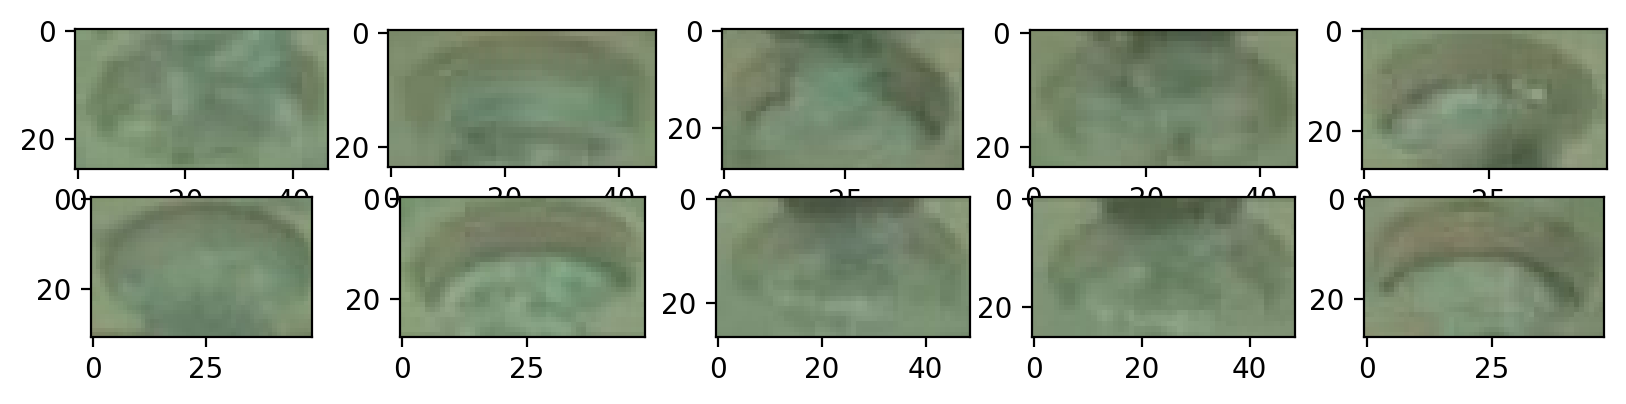

In [8]:
import os
import cv2

imgs = [cv2.imread(f'./dataset/train/{fn}') for fn in os.listdir('./dataset/train/')]

fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(10, 2))
for i, img in enumerate(imgs[:10]):
  axis[i // 5, i % 5].imshow(img)
plt.show()

In [9]:
input_shape = (np.median([e.shape[0] for e in imgs]).astype(int),
               np.median([e.shape[1]for e in imgs]).astype(int))

In [10]:
def preprocess_images(imgs, input_shape):
  imgs = [cv2.cvtColor(e, cv2.COLOR_RGB2GRAY) for e in imgs]
  imgs = [cv2.resize(e, input_shape, interpolation=cv2.INTER_CUBIC) for e in imgs]
  imgs = np.array(imgs) / 255
  return torch.Tensor(imgs).to(device)

In [11]:
imgs = preprocess_images(imgs, input_shape)
data = torch.utils.data.DataLoader(imgs, batch_size=128, shuffle=True)

# Model init

In [12]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(1296, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [13]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1296)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 48, 27))

In [14]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Model train

In [29]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    history = []

    for epoch in range(epochs):
        losses = 0
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            losses += loss
            loss.backward()
            opt.step()

        history.append(float(losses / len(data)))
        if epoch % 10 == 9:
          print(epoch, history[-1])
    return autoencoder, history

In [30]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

autoencoder, history = train(autoencoder, data, epochs=100)

9 33393.62890625
19 33243.98828125
29 33089.15234375
39 33078.67578125
49 33075.06640625
59 33051.93359375
69 33065.49609375
79 33052.61328125
89 33042.88671875
99 33031.546875


# Thresh selection

In [31]:
proliv_imgs = [cv2.imread(f'./dataset/proliv/{fn}') for fn in os.listdir('./dataset/proliv/')]
proliv_imgs = preprocess_images(proliv_imgs, input_shape)
proliv_imgs.size()

torch.Size([154, 48, 27])

In [32]:
train_pred = autoencoder(imgs)
proliv_pred = autoencoder(proliv_imgs)

In [33]:
train_mse = [((x - x_pred)**2).sum() for (x, x_pred) in zip(imgs, train_pred)]
proliv_mse = [((x - x_pred)**2).sum() for (x, x_pred) in zip(proliv_imgs, proliv_pred)]

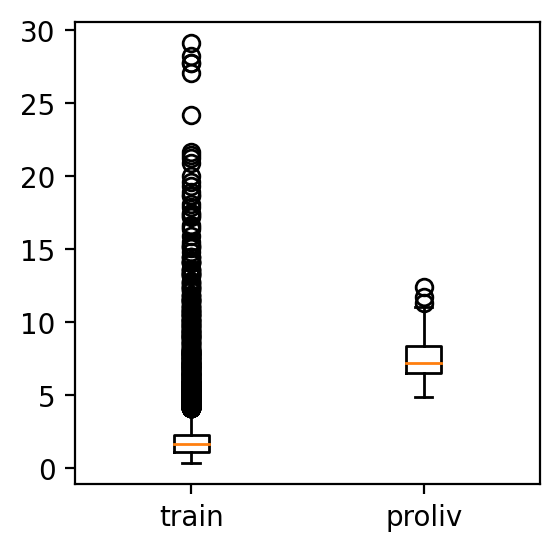

In [34]:
mse = {'train': [e.detach().cpu().numpy() for e in train_mse],
       'proliv': [e.detach().cpu().numpy() for e in proliv_mse]}

fig, ax = plt.subplots(figsize=(3, 3))
ax.boxplot(mse.values())
ax.set_xticklabels(mse.keys())
plt.show()

In [35]:
# Выберем порог по минимальному значению MSE для пролива
thresh = float(min(mse['proliv']))

In [45]:
thresh

4.869115352630615

# Calc score

In [36]:
def classify_proliv(x, x_pred, thresh):
  return ((x - x_pred)**2).sum() > thresh

In [37]:
with open('./dataset/test/test_annotation.txt', 'r') as f:
  lines = f.readlines()

In [38]:
y_test = [int(line.split()[-1]) for line in lines]
x_test = [cv2.imread(f'./dataset/test/imgs/{line.split()[0]}') for line in lines]
x_test = preprocess_images(x_test, input_shape)

In [39]:
x_test_pred = autoencoder(x_test)
y_test_pred = [int(classify_proliv(x_test[i], x_test_pred[i], thresh).cpu().detach())
               for i in range(x_test.size(0))]

In [40]:
def get_scores(y, y_pred):
  scores = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
  for i in range(len(y)):
    if y[i] == 0 and y_pred[i] == 0:
      scores['TN'] += 1
    elif y[i] == 1 and y_pred[i] == 1:
      scores['TP'] += 1
    elif y[i] == 0 and y_pred[i] == 1:
      scores['FP'] += 1
    else:
      scores['FN'] += 1
  return scores


In [41]:
scores = get_scores(y_test, y_test_pred)
print(f'True_positive_rate: {round(scores["TP"]/(scores["TP"]+scores["FN"]), 4)}, True_negative_rate: {round(scores["TN"]/(scores["TN"]+scores["FP"]), 4)}')

True_positive_rate: 0.9147, True_negative_rate: 0.812


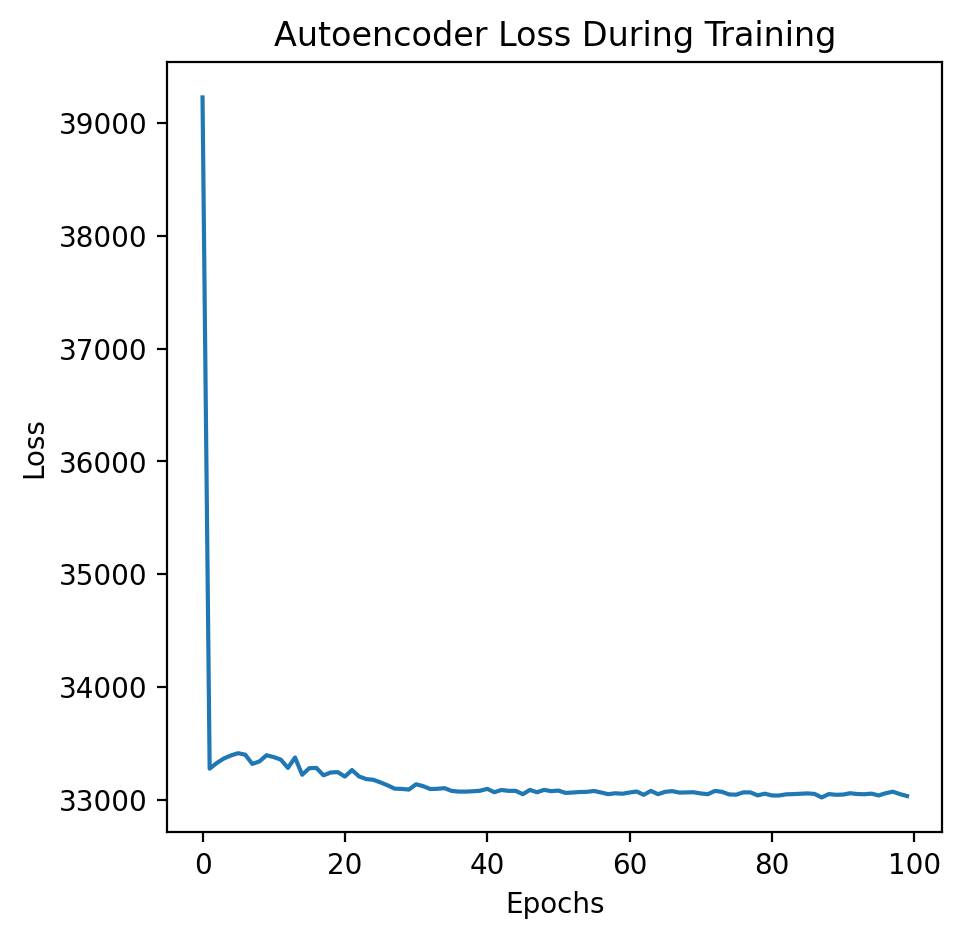

In [44]:
plt.figure(figsize=(5,5))
plt.title("Autoencoder Loss During Training")
plt.plot(history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()